In [1]:
# Import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
# Configuration 

REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

# Dataset 1: New dataset with Weak link scores with 14 categories
weaklink_scores_df = pd.read_csv(os.path.join(DATA_DIR,"scores_and_weaklink.csv"))

# Dataset 2: Movement features 38 features
movement_features_df = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))

print("Dataset 1 - Weak Link Scores:")
print(f"Shape: {weaklink_scores_df.shape}")
print(f"Columns: {list(weaklink_scores_df.columns)}")
print("\nFirst few rows:")
print(weaklink_scores_df.head(2))

print("\n\n")

print("Dataset 2 - Movement Features:")
print(f"Shape: {movement_features_df.shape}")
print(f"Columns: {list(movement_features_df.columns)[:10]}...") 
print("\nFirst few rows:")
print(movement_features_df.head(2))

Dataset 1 - Weak Link Scores:
Shape: (2096, 17)
Columns: ['ID', 'Date', 'SCORE', 'ForwardHead', 'LeftArmFallForward', 'RightArmFallForward', 'LeftShoulderElevation', 'RightShoulderElevation', 'ExcessiveForwardLean', 'LeftAsymmetricalWeightShift', 'RightAsymmetricalWeightShift', 'LeftKneeMovesInward', 'RightKneeMovesInward', 'LeftKneeMovesOutward', 'RightKneeMovesOutward', 'LeftHeelRises', 'RightHeelRises']

First few rows:
                                            ID       Date     SCORE  \
0  cf0e95ab-d6ec-475a-9cc0-c9444b8dd080.Kinect  7/19/2018  0.612532   
1  6210cc6d-575d-4e9f-bab1-4fe1da2a30a3.Kinect  7/30/2018  0.388809   

   ForwardHead  LeftArmFallForward  RightArmFallForward  \
0         0.31                1.34                 1.15   
1         1.49                1.42                 1.39   

   LeftShoulderElevation  RightShoulderElevation  ExcessiveForwardLean  \
0                   0.33                    0.49                  0.00   
1                   0.00         


Weakest Link Distribution:
WeakestLink
LeftArmFallForward              629
RightArmFallForward             472
RightKneeMovesOutward           278
RightShoulderElevation          250
ForwardHead                     117
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64


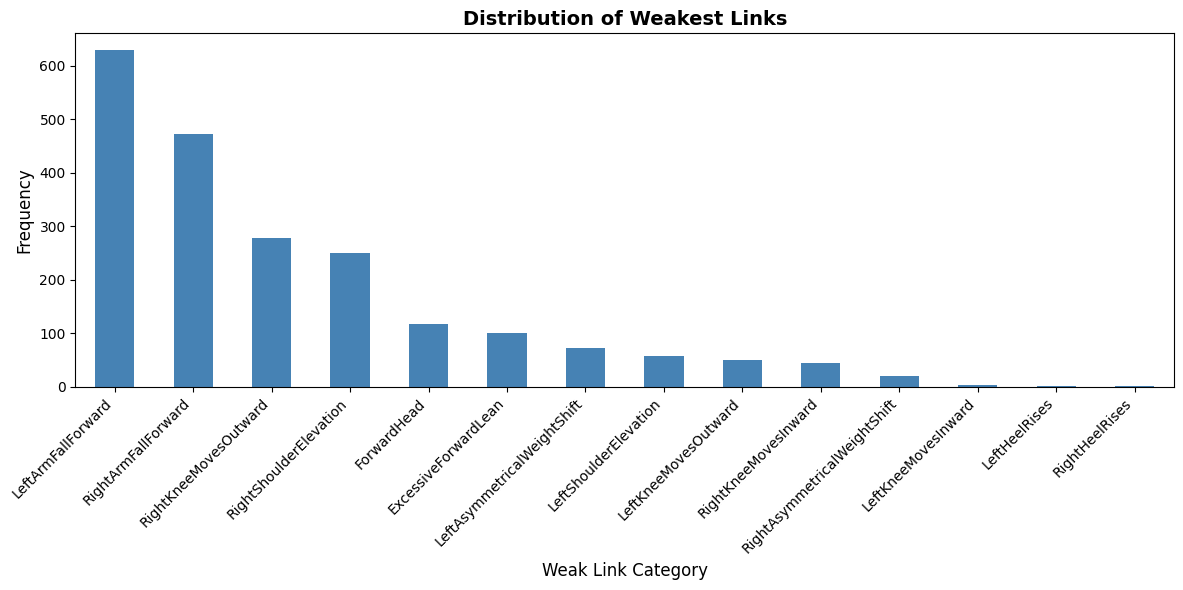

In [3]:
# Define the 14 weak link categories (column names)
weaklink_categories = [
    "ForwardHead",
    "LeftArmFallForward", "RightArmFallForward",
    "LeftShoulderElevation", "RightShoulderElevation",
    "ExcessiveForwardLean",
    "LeftAsymmetricalWeightShift", "RightAsymmetricalWeightShift",
    "LeftKneeMovesInward", "RightKneeMovesInward",
    "LeftKneeMovesOutward", "RightKneeMovesOutward",
    "LeftHeelRises", "RightHeelRises",
]

# For each row, find the column name with the maximum score
# This is our TARGET variable (what we want to predict)
weaklink_scores_df['WeakestLink'] = weaklink_scores_df[weaklink_categories].idxmax(axis=1)

print(f"\nWeakest Link Distribution:")
print(weaklink_scores_df['WeakestLink'].value_counts())

# Visualize the distribution
plt.figure(figsize=(12, 6))
weaklink_scores_df['WeakestLink'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Weakest Links', fontsize=14, fontweight='bold')
plt.xlabel('Weak Link Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# Keep only ID and WeakestLink from the first dataset
target_df = weaklink_scores_df[['ID', 'WeakestLink']].copy()

# Join with movement features dataset
merged_df = movement_features_df.merge(target_df, on='ID', how='inner')

print(f"Datasets merged successfully!")
print(f"Merged dataset shape: {merged_df.shape}")
print(f"\nColumns in merged dataset:")
print(list(merged_df.columns))
print(f"\nFirst few rows:")
print(merged_df.head())

# Check for missing values
print(f"\nMissing values:")
print(merged_df.isnull().sum().sum())

Datasets merged successfully!
Merged dataset shape: (2094, 44)

Columns in merged dataset:
['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_25_NASM_

In [5]:
# Drop non-feature columns 
exclude_from_X = ['ID', 'WeakestLink']
feature_columns = [col for col in merged_df.columns if col not in exclude_from_X]

X = merged_df[feature_columns].copy()
y = merged_df['WeakestLink'].copy()

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Feature names: {feature_columns[:10]}...")  # Show first 10
print(f"\nNumber of classes: {y.nunique()}")
print(f"Classes: {sorted(y.unique())}")

Features (X) shape: (2094, 42)
Target (y) shape: (2094,)

Number of features: 42
Feature names: ['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation']...

Number of classes: 14
Classes: ['ExcessiveForwardLean', 'ForwardHead', 'LeftArmFallForward', 'LeftAsymmetricalWeightShift', 'LeftHeelRises', 'LeftKneeMovesInward', 'LeftKneeMovesOutward', 'LeftShoulderElevation', 'RightArmFallForward', 'RightAsymmetricalWeightShift', 'RightHeelRises', 'RightKneeMovesInward', 'RightKneeMovesOutward', 'RightShoulderElevation']


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())

Training set size: 1675 samples
Testing set size: 419 samples

Training set class distribution:
WeakestLink
LeftArmFallForward              500
RightArmFallForward             373
RightKneeMovesOutward           228
RightShoulderElevation          203
ForwardHead                      91
ExcessiveForwardLean             79
LeftAsymmetricalWeightShift      57
LeftShoulderElevation            47
LeftKneeMovesOutward             40
RightKneeMovesInward             34
RightAsymmetricalWeightShift     17
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64


In [7]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def train_and_evaluate_variants(X_train, X_test, y_train, y_test, models_dict):
    results = []
    trained_models = {} 
    for name, model in models_dict.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            error_rate = 1 - accuracy 
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Error Rate': error_rate,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
            trained_models[name] = model  # Store trained model
        except Exception as e:
            print(f"Failed to train {name}: {e}")

    results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
    return results_df, trained_models

In [9]:
# Train different model variants

models_14class = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state =42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

print("Models defined:")
print("Parametric:", ['Logistic Regression', 'Naive Bayes', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis'])
print("Non-Parametric:", ['KNN (k=3)', 'KNN (k=5)', 'KNN (k=7)'])

Models defined:
Parametric: ['Logistic Regression', 'Naive Bayes', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis']
Non-Parametric: ['KNN (k=3)', 'KNN (k=5)', 'KNN (k=7)']


In [10]:
# 2. Call the function
results_14class_baseline, trained_14class = train_and_evaluate_variants(X_train_scaled, X_test_scaled, y_train, y_test, models_14class)

# 3. View results
print("\n Classification Performance (Baseline - 14 classes): ")
display(results_14class_baseline)

Failed to train QDA: y has only 1 sample in class RightHeelRises, covariance is ill defined.

 Classification Performance (Baseline - 14 classes): 


,Model,Accuracy,Error Rate,Precision,Recall,F1-Score
2,LDA,0.579952,0.420048,0.594921,0.579952,0.580049
0,Logistic Regression,0.548926,0.451074,0.623611,0.548926,0.566248
3,KNN (k=5),0.553699,0.446301,0.556792,0.553699,0.546164
5,KNN (k=10),0.551313,0.448687,0.573710,0.551313,0.542103
4,KNN (k=7),0.544153,0.455847,0.542687,0.544153,0.538519
1,Naive Bayes,0.431981,0.568019,0.513408,0.431981,0.447074


In [11]:
# Identify champion
champion_14class_baseline = results_14class_baseline.iloc[0]['Model']
champion_14class_f1_baseline = results_14class_baseline.iloc[0]['F1-Score']

print(f"\nCHAMPION: {champion_14class_baseline}")
print(f"F1-Score: {champion_14class_f1_baseline:.4f}")


CHAMPION: LDA
F1-Score: 0.5800


### Hyperparameter tuning (14-class)

In [12]:
# Define tuning configurations for top 3 models
tuning_configs_14class = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'saga'],
            'class_weight': [None, 'balanced']  
        }
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen']
        }
    },
    'KNN (k=5)': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

tuning_results_14class = []
best_models_14class = {}

for name, config in tuning_configs_14class.items():
    print(f"\nTuning {name}...")
    print(f"  Parameters to test: {config['params']}")
    
    # GridSearchCV with cross-validation
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,  # 5-fold cross-validation
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit with cross-validation
    grid.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid.best_estimator_
    best_models_14class[name] = best_model
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    tuning_results_14class.append({
        'Model': f"{name} (Tuned)",
        'Best Params': str(grid.best_params_),
        'CV Score': grid.best_score_,  
        'Test Accuracy': accuracy,
        'Test F1-Score': f1,
        'Improvement': f1 - results_14class_baseline[results_14class_baseline['Model']==name]['F1-Score'].values[0]
    })
    
    print(f"Best params: {grid.best_params_}")
    print(f"CV F1-Score: {grid.best_score_:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Improvement: {tuning_results_14class[-1]['Improvement']:+.4f}")

tuning_df_14class = pd.DataFrame(tuning_results_14class).sort_values('Test F1-Score', ascending=False)

print("\n")
print("Hyperparameter Tuning Results (14-class):")
print("\n")
display(tuning_df_14class)


Tuning Logistic Regression...
  Parameters to test: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'saga'], 'class_weight': [None, 'balanced']}
Best params: {'C': 10, 'class_weight': None, 'solver': 'lbfgs'}
CV F1-Score: 0.5968
Test F1-Score: 0.6195
Improvement: +0.0532

Tuning LDA...
  Parameters to test: {'solver': ['svd', 'lsqr', 'eigen']}
Best params: {'solver': 'svd'}
CV F1-Score: 0.5774
Test F1-Score: 0.5800
Improvement: +0.0000

Tuning KNN (k=5)...
  Parameters to test: {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
Best params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
CV F1-Score: 0.5560
Test F1-Score: 0.5571
Improvement: +0.0110


Hyperparameter Tuning Results (14-class):




,Model,Best Params,CV Score,Test Accuracy,Test F1-Score,Improvement
0,Logistic Regression (Tuned),"{'C': 10, 'class_weight': None, 'solver': 'lbf...",0.596789,0.620525,0.619470,0.053222
1,LDA (Tuned),{'solver': 'svd'},0.577370,0.579952,0.580049,0.000000
2,KNN (k=5) (Tuned),"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.555957,0.568019,0.557133,0.010970


### Trying the alternative option (mentioned in slide 6 - Alternatively find the body region with the weakest link, e.g., upper body (shoulders and arms) vs lower body (hips and legs) )

In [13]:
# The alternative approach was chosen because of severe class imbalance. Highest clss shows 500 labels but lowest shows only 1.
# Also quadratic discriminant analysis was not possible in previous example due to very few data points belonging to a class.

In [14]:
# Define the groups as mentioned in Slide 6 into 3 distinct regions
def get_region(label):
    upper = ["ForwardHead", "LeftArmFallForward", "RightArmFallForward", 
              "LeftShoulderElevation", "RightShoulderElevation"]
    lower = ["LeftKneeMovesInward", "RightKneeMovesInward", 
             "LeftKneeMovesOutward", "RightKneeMovesOutward", 
             "LeftHeelRises", "RightHeelRises", 
             "ExcessiveForwardLean", 
             "LeftAsymmetricalWeightShift", "RightAsymmetricalWeightShift"]
    
    if label in upper: 
        return "Upper Body"
    else: 
        return "Lower Body"

merged_df['WeakestRegion'] = merged_df['WeakestLink'].apply(get_region)

print("New Class Distribution based on two Body Regions")
print(merged_df['WeakestRegion'].value_counts())
print(merged_df.shape)
merged_df.head(3)

New Class Distribution based on two Body Regions
WeakestRegion
Upper Body    1525
Lower Body     569
Name: count, dtype: int64
(2094, 45)


,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation,EstimatedScore,ID,WeakestLink,WeakestRegion
0,0.323667,0.538020,0.815878,0.346724,0.382114,0.302248,0.947872,0.275945,0.521760,0.457198,...,0.552846,0.648972,0.578192,0.560019,0.821616,0.818747,0.209947,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,RightShoulderElevation,Upper Body
1,0.323699,0.443807,0.306552,0.823529,0.188905,0.497370,0.140124,0.664275,0.521760,0.729316,...,0.805356,0.848876,0.889048,0.816834,0.307987,0.248207,0.457198,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,RightArmFallForward,Upper Body
2,0.848327,0.603539,0.373984,0.346724,0.590626,0.341942,0.298900,0.276901,0.623625,0.658058,...,0.690579,0.648972,0.578192,0.555715,0.218556,0.235294,0.107126,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,LeftArmFallForward,Upper Body


In [15]:
# Prepare data for region wise classification

exclude_region = ['ID', 'WeakestLink', 'WeakestRegion']
features_region = [c for c in merged_df.columns if c not in exclude_region]

X_region = merged_df[features_region].copy()
y_region = merged_df['WeakestRegion'].copy()

X_train_region, X_test_region, y_train_region, y_test_region = train_test_split(
    X_region, y_region, test_size=0.2, random_state=42, stratify=y_region
)

# Scaling
scaler_region = StandardScaler()
X_train_region_scaled = scaler_region.fit_transform(X_train_region)
X_test_region_scaled = scaler_region.transform(X_test_region)

print(f"\nTraining set: {X_train_region.shape[0]} samples")
print(f"Test set: {X_test_region.shape[0]} samples")


Training set: 1675 samples
Test set: 419 samples


In [16]:
models_region = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

# Train and evaluate
results_region_baseline, trained_region = train_and_evaluate_variants(
    X_train_region_scaled, X_test_region_scaled, 
    y_train_region, y_test_region, 
    models_region
)

# 3. View results
print("\nFinal Classification Performance")
display(results_region_baseline)


Final Classification Performance


,Model,Accuracy,Error Rate,Precision,Recall,F1-Score
2,LDA,0.842482,0.157518,0.837328,0.842482,0.837989
6,KNN (k=10),0.832936,0.167064,0.826575,0.832936,0.824195
5,KNN (k=7),0.832936,0.167064,0.827125,0.832936,0.822706
4,KNN (k=5),0.825776,0.174224,0.818545,0.825776,0.818477
0,Logistic Regression,0.809069,0.190931,0.833434,0.809069,0.815823
1,Naive Bayes,0.770883,0.229117,0.763969,0.770883,0.766729
3,QDA,0.548926,0.451074,0.688926,0.548926,0.570997


In [17]:
champion_region_baseline = results_region_baseline.iloc[0]['Model']
champion_region_f1_baseline = results_region_baseline.iloc[0]['F1-Score']
print(f"\nBaseline Champion (Body Regions): {champion_region_baseline}")
print(f"F1-Score: {champion_region_f1_baseline:.4f}")


Baseline Champion (Body Regions): LDA
F1-Score: 0.8380


### Hyperparameter tuning (Body regions)

In [18]:
tuning_configs_region = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'saga', 'newton-cg']
        }
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen']
        }
    },
    'KNN (k=10)': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [7, 9, 10, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    }
}

tuning_results_region = []
best_models_region = {}

for name, config in tuning_configs_region.items():
    print(f"\nTuning {name}...")
    print(f"  Parameters to test: {config['params']}")
    
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train_region_scaled, y_train_region)
    
    best_model = grid.best_estimator_
    best_models_region[name] = best_model
    
    y_pred = best_model.predict(X_test_region_scaled)
    
    accuracy = accuracy_score(y_test_region, y_pred)
    f1 = f1_score(y_test_region, y_pred, average='weighted', zero_division=0)
    
    tuning_results_region.append({
        'Model': f"{name} (Tuned)",
        'Best Params': str(grid.best_params_),
        'CV Score': grid.best_score_,
        'Test Accuracy': accuracy,
        'Test F1-Score': f1,
        'Improvement': f1 - results_region_baseline[results_region_baseline['Model']==name]['F1-Score'].values[0]
    })
    
    print(f"Best params: {grid.best_params_}")
    print(f"CV F1-Score: {grid.best_score_:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Improvement: {tuning_results_region[-1]['Improvement']:+.4f}")

tuning_df_region = pd.DataFrame(tuning_results_region).sort_values('Test F1-Score', ascending=False)

print("Hyperparameter Tuning Results (Body Regions):")
print("\n")
display(tuning_df_region)


Tuning Logistic Regression...
  Parameters to test: {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'saga', 'newton-cg']}
Best params: {'C': 0.1, 'solver': 'lbfgs'}
CV F1-Score: 0.8290
Test F1-Score: 0.8137
Improvement: -0.0022

Tuning LDA...
  Parameters to test: {'solver': ['svd', 'lsqr', 'eigen']}
Best params: {'solver': 'svd'}
CV F1-Score: 0.8434
Test F1-Score: 0.8380
Improvement: +0.0000

Tuning KNN (k=10)...
  Parameters to test: {'n_neighbors': [7, 9, 10, 11, 13, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
Best params: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
CV F1-Score: 0.8643
Test F1-Score: 0.8335
Improvement: +0.0093
Hyperparameter Tuning Results (Body Regions):




,Model,Best Params,CV Score,Test Accuracy,Test F1-Score,Improvement
1,LDA (Tuned),{'solver': 'svd'},0.843434,0.842482,0.837989,0.00000
2,KNN (k=10) (Tuned),"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.864273,0.844869,0.833524,0.00933
0,Logistic Regression (Tuned),"{'C': 0.1, 'solver': 'lbfgs'}",0.829037,0.806683,0.813662,-0.00216


### FEature engineering

In [19]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_region)
X_test_poly = poly.transform(X_test_region)

print(f"Original features: {X_train_region.shape[1]}")
print(f"After polynomial transformation: {X_train_poly.shape[1]}")
print(f"New features created: {X_train_poly.shape[1] - X_train_region.shape[1]}")

# Scale polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Train champion model with polynomial features
print(f"\nTraining Logistic Regression with polynomial features...")
lr_poly = LogisticRegression(max_iter=1000, random_state=42)
lr_poly.fit(X_train_poly_scaled, y_train_region)

y_pred_poly = lr_poly.predict(X_test_poly_scaled)
poly_accuracy = accuracy_score(y_test_region, y_pred_poly)
poly_f1 = f1_score(y_test_region, y_pred_poly, average='weighted')

print(f"\nPolynomial Features Results:")
print(f"Accuracy: {poly_accuracy:.4f}")
print(f"F1-Score: {poly_f1:.4f}")
print(f"Baseline F1: {champion_region_f1_baseline:.4f}")
print(f"Improvement: {poly_f1 - champion_region_f1_baseline:+.4f}")

Original features: 42
After polynomial transformation: 903
New features created: 861

Training Logistic Regression with polynomial features...

Polynomial Features Results:
Accuracy: 0.8496
F1-Score: 0.8498
Baseline F1: 0.8380
Improvement: +0.0119


In [20]:
all_iterations = pd.DataFrame([
    # 14-class approaches
    {'Approach': '14-Class', 'Iteration': 'Baseline', 
     'Model': champion_14class_baseline, 
     'F1-Score': champion_14class_f1_baseline},
    {'Approach': '14-Class', 'Iteration': 'Tuned', 
     'Model': tuning_df_14class.iloc[0]['Model'], 
     'F1-Score': tuning_df_14class.iloc[0]['Test F1-Score']},
    
    # Body region approaches
    {'Approach': 'Body Regions', 'Iteration': 'Baseline', 
     'Model': champion_region_baseline, 
     'F1-Score': champion_region_f1_baseline},
    {'Approach': 'Body Regions', 'Iteration': 'Tuned', 
     'Model': tuning_df_region.iloc[0]['Model'], 
     'F1-Score': tuning_df_region.iloc[0]['Test F1-Score']},
    {'Approach': 'Body Regions', 'Iteration': 'Polynomial', 
     'Model': 'LR + Poly Features', 
     'F1-Score': poly_f1},
])

all_iterations = all_iterations.sort_values('F1-Score', ascending=False)

print("\nALL ITERATIONS RANKED BY PERFORMANCE:")
display(all_iterations)

# Identify overall champion
final_champion_row = all_iterations.iloc[0]
print("FINAL CHAMPION MODEL")
print(f"Approach: {final_champion_row['Approach']}")
print(f"Iteration: {final_champion_row['Iteration']}")
print(f"Model: {final_champion_row['Model']}")
print(f"F1-Score: {final_champion_row['F1-Score']:.4f}")
print(f"Improvement over baseline: +{final_champion_row['F1-Score'] - champion_region_f1_baseline:.4f}")


ALL ITERATIONS RANKED BY PERFORMANCE:


,Approach,Iteration,Model,F1-Score
4,Body Regions,Polynomial,LR + Poly Features,0.849847
3,Body Regions,Tuned,LDA (Tuned),0.837989
2,Body Regions,Baseline,LDA,0.837989
1,14-Class,Tuned,Logistic Regression (Tuned),0.619470
0,14-Class,Baseline,LDA,0.580049


FINAL CHAMPION MODEL
Approach: Body Regions
Iteration: Polynomial
Model: LR + Poly Features
F1-Score: 0.8498
Improvement over baseline: +0.0119



Classification Report:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Lower Body       0.72      0.73      0.72       114
  Upper Body       0.90      0.90      0.90       305

    accuracy                           0.85       419
   macro avg       0.81      0.81      0.81       419
weighted avg       0.85      0.85      0.85       419



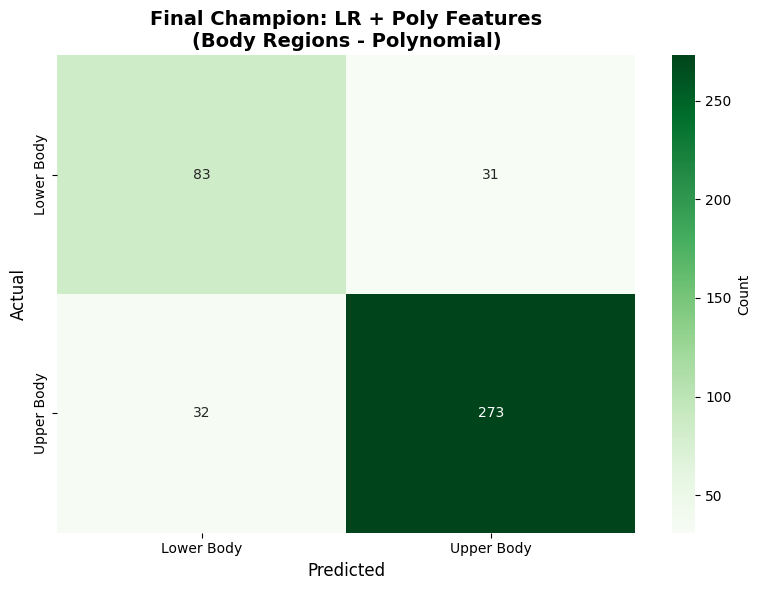

In [21]:
# Determine which champion to use
if final_champion_row['Approach'] == 'Body Regions':
    if final_champion_row['Iteration'] == 'Tuned':
        final_model = best_models_region[tuning_df_region.iloc[0]['Model'].replace(' (Tuned)', '')]
        X_test_final = X_test_region_scaled
        y_test_final = y_test_region
    elif final_champion_row['Iteration'] == 'Polynomial':
        final_model = lr_poly
        X_test_final = X_test_poly_scaled
        y_test_final = y_test_region
    else:  # Baseline
        final_model = trained_region[champion_region_baseline]
        X_test_final = X_test_region_scaled
        y_test_final = y_test_region
    
    classes = sorted(y_region.unique())
else:  # 14-class
    final_model = best_models_14class[tuning_df_14class.iloc[0]['Model'].replace(' (Tuned)', '')]
    X_test_final = X_test_scaled
    y_test_final = y_test
    classes = sorted(y.unique())

# Get predictions
y_pred_final = final_model.predict(X_test_final)

# Classification report
print("\nClassification Report:")
print("-"*100)
print(classification_report(y_test_final, y_pred_final, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred_final, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'})
plt.title(f'Final Champion: {final_champion_row["Model"]}\n({final_champion_row["Approach"]} - {final_champion_row["Iteration"]})', 
          fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


In [22]:
# Save the champion model
model_filename = 'final_champion_model_A3.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Model saved: {model_filename}")

Model saved: final_champion_model_A3.pkl
